In [10]:
# NOTE !pip install -Uq python-igraph cairocffi 
!pip install -Uq networkx hypernetx celluloid
import igraph as ig
print('igraph version:', ig.__version__)

igraph version: 0.9.8


IGRAPH U--- 3 2 -- 


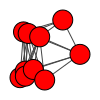

In [7]:
g = ig.Graph()

g.add_vertices(3)
g.add_edges([(0,1), (1,2)])
# g.vs[0]['name'] = 'test'
# g.vs[0].attributes()

# print(g)
ig.summary(g)

g =ig.Graph.GRG(10, .8)

ig.plot(g, bbox=(100,100))

Clustering with 10 elements and 8 clusters
[0] 0
[1] 1, 2, 7
[2] 3
[3] 4
[4] 5
[5] 6
[6] 8
[7] 9


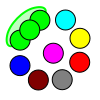

In [8]:
import random
random.seed(42)

import matplotlib.pyplot as plt

# a random graph
g = ig.Graph.Erdos_Renyi(10,.02)

# detect communities
comms = g.community_multilevel()

# plot and save
g_plot = ig.plot(comms, mark_groups = True, inline=True, bbox=(100,100))

g_plot.save('outputs/multilevel_community_in_graphs.png')

print(comms)
g_plot


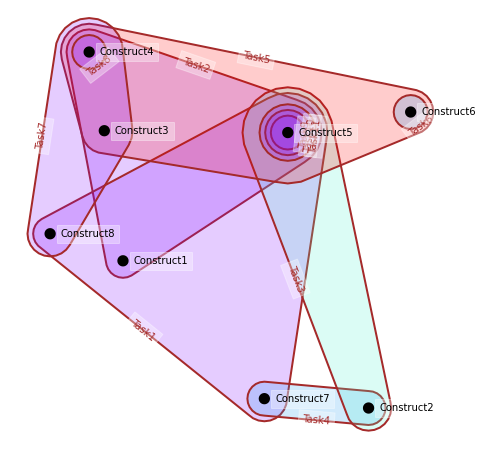

In [22]:
import matplotlib.pyplot as plt
import hypernetx as hnx

communities = {
    'Construct1': ('Task1', 'Task2'),
    'Construct2': ('Task3', 'Task4'),
    'Construct3': ('Task5', 'Task2', 'Task7'),
    'Construct4': ('Task5', 'Task2', 'Task7', 'Task8'),
    'Construct5': ('Task5', 'Task1', 'Task2', 'Task9', 'Task3', 'Task10', 'Task11'),
    'Construct6': ('Task5', 'Task6'),
    'Construct7': ('Task1', 'Task4'),
    'Construct8': ('Task1', 'Task7')
}

import numpy as np

H = hnx.Hypergraph(communities)

# face colors
cmap = plt.cm.rainbow
edge_sizes = np.array([len(e) for e in H.edges()])
norm = plt.Normalize(edge_sizes.min(), edge_sizes.max())
facecolors = cmap([norm(c) for c in edge_sizes]) * (1, 1, 1, 0.2)

hnx.draw(H.dual(),
        edges_kwargs={
            'linewidths': 2,
            'edgecolors': 'brown',
            'facecolors': facecolors
        },
         nodes_kwargs={
    # 'node_size': [np.random.randint(3,5) for n in H.collapse_nodes()]
})

# hnx.draw(H.dual())

plt.show()
